## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipaddress

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

## Data loading

In [2]:
col_names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

def load_dataframe(name):
    return pd.read_csv(f"data/training/{name}_flows_cut.csv", header = None, names = col_names)

def load_test_dataframe(name):
    return pd.read_csv(f"data/test/{name}_flows_cut.csv", header = None, names = col_names)

In [3]:
background = load_dataframe("background")
blacklist  = load_dataframe("blacklist")
sshscan    = load_dataframe("sshscan")
spam       = load_dataframe("spam")

test_background = load_test_dataframe("background")
test_blacklist  = load_test_dataframe("blacklist")
test_sshscan    = load_test_dataframe("sshscan")
test_botnet     = load_test_dataframe("botnet")
test_scan11     = load_test_dataframe("scan11")
test_scan44     = load_test_dataframe("scan44")
test_spam       = load_test_dataframe("spam")
test_dos        = load_test_dataframe("dos")

attacks_dataframes = [blacklist, sshscan, spam]
test_attacks_dataframes = [test_blacklist, test_sshscan, test_botnet, test_scan11, test_scan44, test_spam, test_dos]

In [4]:
def cast_dataframe(df):
    # Convert timestamp to epoch integer
    df.end_epoch = pd.to_datetime(df.end_epoch).view(np.int64)

    # Convert attack to boolean
    df.attack = df.attack.apply(lambda x: x != 'background')

    # Convert IPs to int
    df.src_ip = df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    df.dst_ip = df.dst_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))

    return df

def get_dataframes(outlier_ratio, num_samples):
    nb_train_attack = int((num_samples * outlier_ratio - len(spam)) // (len(attacks_dataframes) - 1))
    nb_test_attack  = int((num_samples * outlier_ratio - len(test_sshscan)) // (len(test_attacks_dataframes) - 1))

    train_dataframes = [df.head(nb_train_attack) for df in attacks_dataframes]
    train_dataframes.append(background.head(num_samples - sum(len(df) for df in train_dataframes)))

    test_dataframes = [df.head(nb_test_attack) for df in test_attacks_dataframes]
    test_dataframes.append(test_background.head(num_samples - sum(len(df) for df in test_dataframes)))

    train_df = cast_dataframe(pd.concat(train_dataframes))
    test_df = cast_dataframe(pd.concat(test_dataframes))

    return train_df, test_df

In [5]:
df, test_df = get_dataframes(0.4, 200000)

In [6]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 200000

Sumber of Nan values: 0

Column number: 13

Column names:
['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

Column types:


end_epoch         int64
duration        float64
src_ip            int64
dst_ip            int64
src_port          int64
dst_port          int64
protocol         object
flags            object
status            int64
service_type      int64
packets           int64
bytes             int64
attack             bool
dtype: object

#### Control of flows

In [7]:
print(f"Number of background exchanges : {len(df[df.attack == False])}")
print(f"Number of attack: {len(df[df.attack])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 120001
Number of attack: 79999
Number of blacklisted IP attack: 500000
Number of ssh scan attack: 500000
Number of spam attack: 41


#### Numeric columns

In [8]:
numeric_df = df._get_numeric_data()
numeric_df.describe()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes
count,2.000000e+05,200000.000000,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.0,200000.000000,200000.000000,2.000000e+05
mean,1.460956e+18,3.686811,1.396791e+09,1.356781e+09,23300.856365,21241.312660,0.0,7.729560,20.632695,1.349295e+04
std,4.075974e+13,14.735915,1.021724e+09,9.942165e+08,24337.400565,24167.354843,0.0,18.507073,329.345748,3.443471e+05
min,1.460938e+18,0.000000,5.400010e+08,4.259593e+06,0.000000,0.000000,0.0,0.000000,1.000000,2.800000e+01
25%,1.460938e+18,0.000000,7.190356e+08,7.190356e+08,80.000000,53.000000,0.0,0.000000,1.000000,9.600000e+01
50%,1.460938e+18,0.780000,7.190363e+08,7.190363e+08,10549.500000,445.000000,0.0,0.000000,5.000000,6.140000e+02
75%,1.460938e+18,4.212000,1.487015e+09,1.301499e+09,48811.250000,46968.250000,0.0,8.000000,13.000000,1.846000e+03
max,1.461503e+18,355.724000,4.294738e+09,4.294738e+09,65535.000000,65535.000000,0.0,224.000000,57598.000000,8.617546e+07


## Dataset Visualisation

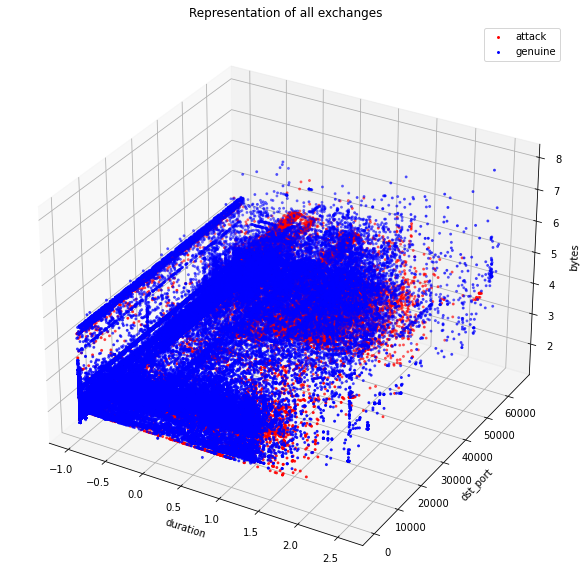

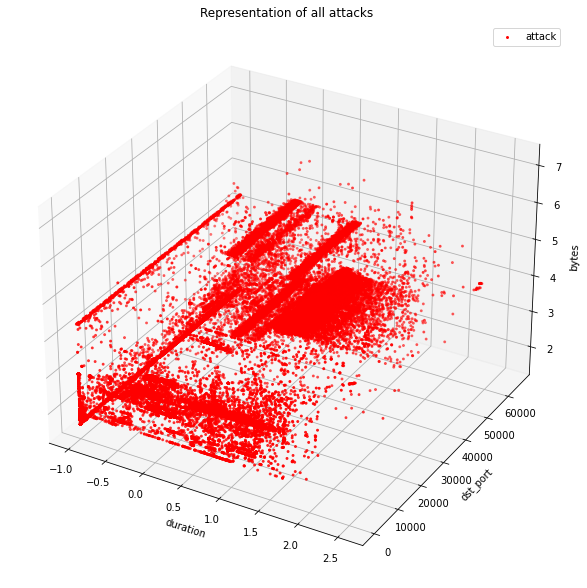

In [9]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    for attack in df.attack.unique():
        df_label = df[df.attack == attack]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x + 0.1), y, np.log10(z), color= 'red' if attack else 'blue' , label='attack' if attack else 'genuine', marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.attack], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')

## Data Cleaning

In [10]:
def one_hot_encoding_dataframes(df, test_df):
    one_hot_encoded_df = pd.get_dummies(df)
    one_hot_encoded_df_test = pd.get_dummies(test_df)

    for column in one_hot_encoded_df.columns:
        if column not in one_hot_encoded_df_test.columns:
            one_hot_encoded_df_test[column] = 0

    for column in one_hot_encoded_df_test.columns:
        if column not in one_hot_encoded_df.columns:
            one_hot_encoded_df[column] = 0
    
    one_hot_encoded_df_test = one_hot_encoded_df_test[one_hot_encoded_df.columns]

    return one_hot_encoded_df, one_hot_encoded_df_test

one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)
display(one_hot_encoded_df.head())
print(one_hot_encoded_df.isna().sum().any())

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RS.,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,0,1,0,0,0,0
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,0,1,0,0,0,0
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,0,1,0,0,0,0
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,0,1,0,0,0,0
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,0


False


## Outlier detection

In [11]:
def describe_precision(col):
    true_positive = df_outliers[(df_outliers["attack"]) & (df_outliers[col])]
    print(f'{len(true_positive)} attacks are labelled as outlier.')

    false_negative = df_outliers[(df_outliers["attack"]) & (df_outliers[col] == False)]
    print(f'{len(false_negative)} attacks are labelled as inliers.')

    false_positive = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col])]
    print(f'{len(false_positive)} genuine exchanges are labelled as outlier.')

    true_negative = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col] == False)]
    print(f'{len(true_negative)} genuine exchanges are labelled as inliers.\n')

    precision = len(true_positive) * 100 / (len(true_positive) + len(false_positive))
    print(f'Precision: {round(precision, 2)}%')

    recall = len(true_positive) * 100 / (len(true_positive) + len(false_negative))
    print(f'Recall: {round(recall, 1)}%')

    true_negative_rate = len(true_negative) * 100 / (len(true_negative) + len(false_positive))
    print(f'True negative rate: {round(true_negative_rate, 2)}%')

    accuracy = (len(true_positive) + len(true_negative)) * 100 / len(df_outliers)
    print(f'Accuracy: {round(accuracy, 2)}%')
    

#### Isolation Forests

In [12]:
outlier_ratio = 0.1
df, test_df = get_dataframes(outlier_ratio, 10000)
one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)

classifier = IsolationForest(contamination=outlier_ratio, n_estimators=50).fit(one_hot_encoded_df.values)
y_pred = classifier.predict(one_hot_encoded_df_test.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,True
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,True
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,True
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,True
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,1460937739000000000,0.000,2403862665,719035623,53,39895,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
8997,1460937739000000000,0.000,2403862665,719035623,53,39992,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
8998,1460937739000000000,0.000,2403862665,719035623,53,40001,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False
8999,1460937739000000000,0.000,2403862665,719035623,53,40190,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False


In [13]:
describe_precision("if_outliers")

999 attacks are labelled as outlier.
0 attacks are labelled as inliers.
5108 genuine exchanges are labelled as outlier.
3893 genuine exchanges are labelled as inliers.

Precision: 16.36%
Recall: 100.0%
True negative rate: 43.25%
Accuracy: 48.92%


#### Local Outlier Factor

In [14]:
outlier_ratio = 0.4
df, test_df = get_dataframes(outlier_ratio, 10000)
one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)

localOutlierFactor = LocalOutlierFactor(contamination=outlier_ratio, n_neighbors=len(df) - 1).fit(one_hot_encoded_df.values)

lof_outliers = localOutlierFactor.fit_predict(one_hot_encoded_df_test.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['lof_outliers'] = [i == -1 for i in  lof_outliers]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,lof_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,True
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,True
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,True
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,True
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,1460937737000000000,0.000,2403862665,719035623,53,54200,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
5997,1460937737000000000,0.000,2403862665,719035623,53,54299,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False
5998,1460937737000000000,0.000,2403862665,719035623,53,54442,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
5999,1460937737000000000,0.000,2403862665,719035623,53,54841,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False


In [15]:
describe_precision("lof_outliers")

3994 attacks are labelled as outlier.
5 attacks are labelled as inliers.
0 genuine exchanges are labelled as outlier.
6001 genuine exchanges are labelled as inliers.

Precision: 100.0%
Recall: 99.9%
True negative rate: 100.0%
Accuracy: 99.95%


In [16]:
from sklearn.ensemble import AdaBoostClassifier

outlier_ratio = 0.4
df, test_df = get_dataframes(outlier_ratio, 100000)
one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)

labels = one_hot_encoded_df['attack']

classifier = AdaBoostClassifier().fit(one_hot_encoded_df, labels)
rfc_outliers = classifier.predict(one_hot_encoded_df_test)

df_outliers = one_hot_encoded_df.copy()
df_outliers['rfc_outliers'] = [i == -1 for i in  rfc_outliers]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,rfc_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,False
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,False
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,False
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,False
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,1460937770000000000,0.000,2403862665,719035623,53,34682,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False
59997,1460937770000000000,0.000,2403862665,719035623,53,34994,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False
59998,1460937770000000000,0.000,2403862665,719035623,53,35150,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
59999,1460937770000000000,0.000,2403862665,719035623,53,35283,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False


In [17]:
describe_precision("rfc_outliers")

0 attacks are labelled as outlier.
39999 attacks are labelled as inliers.
0 genuine exchanges are labelled as outlier.
60001 genuine exchanges are labelled as inliers.



ZeroDivisionError: division by zero

#### Elliptic Envelope

In [22]:
outlier_ratio = 0.15
df, test_df = get_dataframes(outlier_ratio, 10000)
one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)

robustCovariance = EllipticEnvelope(contamination=outlier_ratio).fit(one_hot_encoded_df.values)
rc_outliers = robustCovariance.predict(one_hot_encoded_df_test.values)


df_outliers = one_hot_encoded_df.copy()
df_outliers['rc_outliers'] = [i == -1 for i in  rc_outliers]
df_outliers

D:\Users\hugol\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,rc_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,True
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,True
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,True
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,True
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8496,1460937738000000000,0.396,707261714,719035603,54575,80,0,0,5,587,...,0,0,0,0,1,0,0,0,0,True
8497,1460937738000000000,0.408,719035603,3543591531,80,47184,0,0,4,1010,...,0,0,0,0,1,0,0,0,0,True
8498,1460937738000000000,0.408,719035603,3543591531,80,47185,0,0,4,928,...,0,0,0,0,1,0,0,0,0,True
8499,1460937738000000000,0.416,2830589213,719035603,59593,443,0,0,8,1246,...,0,0,0,0,1,0,0,0,0,True


In [23]:
describe_precision("rc_outliers")

1499 attacks are labelled as outlier.
0 attacks are labelled as inliers.
8501 genuine exchanges are labelled as outlier.
0 genuine exchanges are labelled as inliers.

Precision: 14.99%
Recall: 100.0%
True negative rate: 0.0%
Accuracy: 14.99%
